### UFC Fight Finish Classification Prediction

In [2]:
#feature importance (trees)
#more models
#feature engineering

### 1) Imports and loading dataset

In [85]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, fbeta_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import imblearn.over_sampling
import imblearn.under_sampling


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [31]:
df = pd.read_csv('ufc-master.csv')

In [32]:
pd.set_option('display.max_columns', None)

In [106]:
df.shape

(4885, 119)

In [109]:
df.finish.value_counts()

U-DEC         1775
KO/TKO        1490
SUB            853
S-DEC          481
M-DEC           32
DQ              14
Overturned       2
Name: finish, dtype: int64

In [33]:
df.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Alexander Volkanovski,Brian Ortega,-180.0,155,55.555556,155.0,2021-09-25,"Las Vegas, Nevada, USA",USA,Red,True,Featherweight,MALE,5,0,1,0,4.15,0.38,1.2,0.87,0.24,6,1,25,1,0,0,1,3,3,0,7,Switch,172.72,175.26,145,0,9,0,6.42,0.56,0.3,1.77,0.34,9,0,28,2,0,1,5,3,0,0,9,Orthodox,167.64,180.34,145,32,30,0,-8,-3,-2,1,-3,-1,0,3,5.08,-5.08,-2,-2.27,0.9,-0.90,1,1,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,Red,U-DEC,NaN,5.0,5:00,1500.0,140.0,500.0,1600.0,400.0,250.0,700.0
1,Valentina Shevchenko,Lauren Murphy,-1375.0,800,7.272727,800.0,2021-09-25,"Las Vegas, Nevada, USA",USA,Red,True,Women's Flyweight,FEMALE,5,0,5,0,3.58,0.38,0.1,1.03,0.34,5,4,32,0,0,3,1,2,1,0,7,Orthodox,165.10,170.18,125,0,7,0,3.21,0.52,0.3,2.62,0.64,7,2,42,7,0,1,4,3,2,0,10,Southpaw,165.10,167.64,125,33,38,0,-2,-2,-3,2,-10,-7,-1,-1,0.00,2.54,5,0.37,-0.2,-1.59,1,1,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,Red,KO/TKO,Punches,4.0,4:00,1140.0,200.0,1800.0,350.0,2800.0,-110.0,2500.0
2,Nick Diaz,Robbie Lawler,140.0,-160,140.000000,62.5,2021-09-25,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,MALE,3,4,0,0,3.73,0.46,0.0,0.66,0.64,5,14,91,5,0,3,4,12,0,0,19,Southpaw,180.34,187.96,170,2,0,0,5.71,0.42,1.0,1.28,0.32,11,7,70,2,0,1,2,10,6,0,19,Southpaw,185.42,193.04,170,38,39,2,0,-6,0,7,21,3,2,-6,-5.08,-5.08,1,-1.98,-1.0,-0.62,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,KO/TKO,Punch,3.0,0:44,644.0,275.0,225.0,800.0,2500.0,650.0,185.0
3,Curtis Blaydes,Jairzinho Rozenstruik,-380.0,290,26.315789,290.0,2021-09-25,"Las Vegas, Nevada, USA",USA,Red,False,Heavyweight,MALE,3,0,1,0,2.80,0.46,0.0,0.00,0.00,4,2,18,0,0,0,0,6,0,0,6,Orthodox,187.96,198.12,242,1,0,0,3.44,0.51,0.0,6.27,0.53,5,3,32,0,0,0,4,5,0,0,9,Orthodox,193.04,203.20,265,30,33,-1,1,-1,-3,-1,-14,0,1,0,-5.08,-5.08,3,-0.64,0.0,-6.27,1,1,6.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,Na

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4885 entries, 0 to 4884
Columns: 119 entries, R_fighter to b_ko_odds
dtypes: bool(1), float64(58), int64(46), object(14)
memory usage: 4.4+ MB


Text(0.5, 1.0, 'Target distribution')

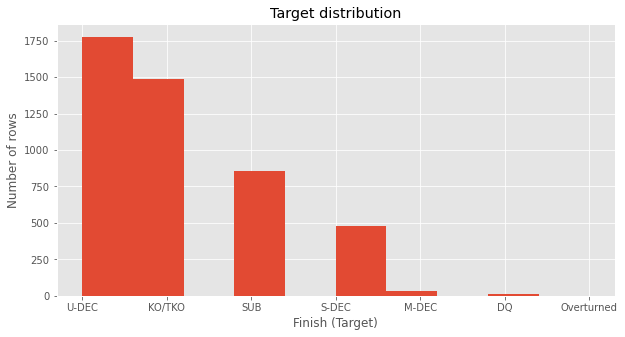

In [123]:
plt.rcParams["figure.figsize"] = (10,5)
df.finish.hist()

plt.xlabel('Finish (Target)')
plt.ylabel('Number of rows')
plt.title('Target distribution')

### 2) EDA and Data Cleaning

### a) Creating a subset with only the important columns

In [35]:
#make a subset of only the columns i need
#how do i know which columns to take and use (by feeling?)

#should i make the target as dummy variable then see the correlation with the other columns and then take
#the columns with the most corr?
df2 = df[['finish', 'no_of_rounds', 'finish_round', 'finish_round_time', 'total_fight_time_secs',
         'B_avg_SIG_STR_landed', 'B_avg_SIG_STR_pct',
         'B_avg_SUB_ATT', 'B_avg_TD_landed', 'B_avg_TD_pct', 'B_win_by_Decision_Majority', 'B_win_by_Decision_Split',
         'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',
         'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs',
         'R_avg_SIG_STR_landed', 'R_avg_SIG_STR_pct', 'R_avg_SUB_ATT', 'R_avg_TD_landed', 'R_avg_TD_pct', 
         'R_win_by_Decision_Majority', 'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous', 'R_win_by_KO/TKO',
         'R_win_by_Submission', 'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs',
         'ko_dif', 'sub_dif', 'height_dif', 'reach_dif', 'sig_str_dif', 'avg_sub_att_dif', 'avg_td_dif',
         'r_dec_odds','b_dec_odds','r_sub_odds', 'b_sub_odds', 'r_ko_odds', 'b_ko_odds']]

In [36]:
df2.head()

,finish,no_of_rounds,finish_round,finish_round_time,total_fight_time_secs,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_Height_cms,R_Reach_cms,R_Weight_lbs,ko_dif,sub_dif,height_dif,reach_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,U-DEC,5,5.0,5:00,1500.0,4.15,0.38,1.2,0.87,0.24,0,0,1,3,3,172.72,175.26,145,6.42,0.56,0.3,1.77,0.34,0,1,5,3,0,167.64,180.34,145,0,3,5.08,-5.08,-2.27,0.9,-0.90,140.0,500.0,1600.0,400.0,250.0,700.0
1,KO/TKO,5,4.0,4:00,1140.0,3.58,0.38,0.1,1.03,0.34,0,3,1,2,1,165.10,170.18,125,3.21,0.52,0.3,2.62,0.64,0,1,4,3,2,165.10,167.64,125,-1,-1,0.00,2.54,0.37,-0.2,-1.59,200.0,1800.0,350.0,2800.0,-110.0,2500.0
2,KO/TKO,3,3.0,0:44,644.0,3.73,0.46,0.0,0.66,0.64,0,3,4,12,0,180.34,187.96,170,5.71,0.42,1.0,1.28,0.32,0,1,2,10,6,185.42,193.04,170,2,-6,-5.08,-5.08,-1.98,-1.0,-0.62,275.0,225.0,800.0,2500.0,650.0,185.0
3,U-DEC,3,3.0,5:00,900.0,2.80,0.46,0.0,0.00,0.00,0,0,0,6,0,187.96,198.12,242,3.44,0.51,0.0,6.27,0.53,0,0,4,5,0,193.04,203.20,265,1,0,-5.08,-5.08,-0.64,0.0,-6.27,180.0,1000.0,1000.0,3500.0,125.0,380.0
4,KO/TKO,3,1.0,4:54,294.0,4.24,0.41,1.1,1.77,0.44,0,0,3,0,3,162.56,162.56,125,6.24,0.50,0.4,2.90,0.55,0,1,5,4,2,154.94,157.48,125,-4,1,7.62,5.08,-2.00,0.7,-1.13,140.0,330.0,1000.0,900.0,225.0,1400.0


In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4885 entries, 0 to 4884
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   finish                       4647 non-null   object 
 1   no_of_rounds                 4885 non-null   int64  
 2   finish_round                 4263 non-null   float64
 3   finish_round_time            4263 non-null   object 
 4   total_fight_time_secs        4263 non-null   float64
 5   B_avg_SIG_STR_landed         3955 non-null   float64
 6   B_avg_SIG_STR_pct            4120 non-null   float64
 7   B_avg_SUB_ATT                4053 non-null   float64
 8   B_avg_TD_landed              4052 non-null   float64
 9   B_avg_TD_pct                 4043 non-null   float64
 10  B_win_by_Decision_Majority   4885 non-null   int64  
 11  B_win_by_Decision_Split      4885 non-null   int64  
 12  B_win_by_Decision_Unanimous  4885 non-null   int64  
 13  B_win_by_KO/TKO   

### b) Cleaning and  Feature Engineering

In [38]:
#function to convert finish_round_time column to integer
#deal with the null (avg)
def to_secs(x):
    l_x = str(x).split(":")
    try:
        in_secs = (int(l_x[0])*60) + int(l_x[1])
    except:
        return np.nan
    return in_secs

In [39]:
df2['finish_round_time'] = df2.finish_round_time.fillna("0:0").apply(to_secs)

<ipython-input-39-b5c402d8553c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['finish_round_time'] = df2.finish_round_time.fillna("0:0").apply(to_secs)


In [40]:
df2.head(3)

,finish,no_of_rounds,finish_round,finish_round_time,total_fight_time_secs,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_Height_cms,R_Reach_cms,R_Weight_lbs,ko_dif,sub_dif,height_dif,reach_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,U-DEC,5,5.0,300,1500.0,4.15,0.38,1.2,0.87,0.24,0,0,1,3,3,172.72,175.26,145,6.42,0.56,0.3,1.77,0.34,0,1,5,3,0,167.64,180.34,145,0,3,5.08,-5.08,-2.27,0.9,-0.90,140.0,500.0,1600.0,400.0,250.0,700.0
1,KO/TKO,5,4.0,240,1140.0,3.58,0.38,0.1,1.03,0.34,0,3,1,2,1,165.10,170.18,125,3.21,0.52,0.3,2.62,0.64,0,1,4,3,2,165.10,167.64,125,-1,-1,0.00,2.54,0.37,-0.2,-1.59,200.0,1800.0,350.0,2800.0,-110.0,2500.0
2,KO/TKO,3,3.0,44,644.0,3.73,0.46,0.0,0.66,0.64,0,3,4,12,0,180.34,187.96,170,5.71,0.42,1.0,1.28,0.32,0,1,2,10,6,185.42,193.04,170,2,-6,-5.08,-5.08,-1.98,-1.0,-0.62,275.0,225.0,800.0,2500.0,650.0,185.0


In [41]:
df2['finish_round_time'].mean() #replace 0 with mean 211 = 3:30


200.66980552712386

In [42]:
# handeling finish round time = 0
df2['finish_round_time'] = df2['finish_round_time'].replace([0],211)

<ipython-input-42-d11aeaeac396>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['finish_round_time'] = df2['finish_round_time'].replace([0],211)


In [43]:
df2['finish_round_time'].value_counts()

300    2136
211     628
299      29
158      23
114      18
       ... 
235       1
5         1
244       1
200       1
11        1
Name: finish_round_time, Length: 293, dtype: int64

In [44]:
#drop rows where finish column string is DQ, Overturned because i only want three classes
df2 = df2[~df2['finish'].isin(['DQ', 'Overturned'])]

In [45]:
# replace finish of S-SEC, M-DEC to U-DEC
df2 = df2.replace({'S-DEC': 'U-DEC'}, regex=True)
df2 = df2.replace({'M-DEC': 'U-DEC'}, regex=True)

In [46]:
df2['finish'].value_counts()

U-DEC     2288
KO/TKO    1490
SUB        853
Name: finish, dtype: int64

In [47]:
#dropping null values in specific columns

df2 = df2.dropna(subset = ['finish'])


In [107]:
df2.shape

(4631, 44)

### c) Filling NaN's with the average

In [48]:
df2.head(3)

,finish,no_of_rounds,finish_round,finish_round_time,total_fight_time_secs,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_Height_cms,R_Reach_cms,R_Weight_lbs,ko_dif,sub_dif,height_dif,reach_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,U-DEC,5,5.0,300,1500.0,4.15,0.38,1.2,0.87,0.24,0,0,1,3,3,172.72,175.26,145,6.42,0.56,0.3,1.77,0.34,0,1,5,3,0,167.64,180.34,145,0,3,5.08,-5.08,-2.27,0.9,-0.90,140.0,500.0,1600.0,400.0,250.0,700.0
1,KO/TKO,5,4.0,240,1140.0,3.58,0.38,0.1,1.03,0.34,0,3,1,2,1,165.10,170.18,125,3.21,0.52,0.3,2.62,0.64,0,1,4,3,2,165.10,167.64,125,-1,-1,0.00,2.54,0.37,-0.2,-1.59,200.0,1800.0,350.0,2800.0,-110.0,2500.0
2,KO/TKO,3,3.0,44,644.0,3.73,0.46,0.0,0.66,0.64,0,3,4,12,0,180.34,187.96,170,5.71,0.42,1.0,1.28,0.32,0,1,2,10,6,185.42,193.04,170,2,-6,-5.08,-5.08,-1.98,-1.0,-0.62,275.0,225.0,800.0,2500.0,650.0,185.0


In [108]:
#counting null values in a column
df['finish'].isna().sum()

238

In [50]:
df2['finish_round'].mean() #1 replace null with mean 2.4
#df2['finish_round'].value_counts()

2.4109202165215344

In [51]:
df2['total_fight_time_secs'].mean() #2 replace null with mean 653
#df2['total_fight_time_secs'].value_counts()

653.4532831254413

In [52]:
# filling all NaN's with the average value
df2 = df2.fillna(df2.mean())

Text(0.5, 1.0, 'Target distribution')

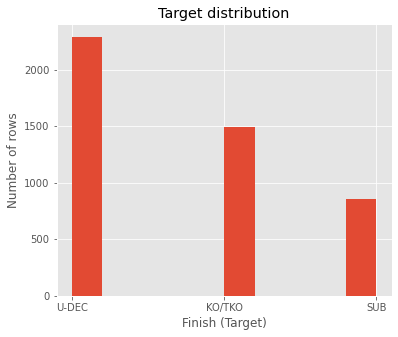

In [127]:
plt.rcParams["figure.figsize"] = (6,5)

y.hist()

plt.xlabel('Finish (Target)')
plt.ylabel('Number of rows')
plt.title('Target distribution')


### 3) Splitting and finding  correlations

In [54]:
X = df2.iloc[:, 1:]
y = df2.iloc[:, 0]

In [56]:
#split the data to 80% X_train, y_train and 20% X_val, y_val
X_train, X_val, y_train, y_val = train_test_split(df2.iloc[:, 1:], df2.iloc[:, 0], 
                                                    test_size = 0.2, random_state=42)

train_df = X_train.copy()
train_df['finish'] = y_train
train_df.head()

,no_of_rounds,finish_round,finish_round_time,total_fight_time_secs,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_Height_cms,R_Reach_cms,R_Weight_lbs,ko_dif,sub_dif,height_dif,reach_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds,finish
926,3,3.0,300,900.0,4.000000,0.500000,2.500000,2.000000,0.330000,0,0,0,0,0,172.72,175.26,135,3.330000,0.510000,0.000000,1.25,0.22,0,0,2,0,0,167.64,162.56,135,0,0,5.08,12.70,0.670000,2.500000,0.750000,155.0,180.0,475.0,1795.0,1075.0,725.0,U-DEC
1580,3,3.0,300,900.0,45.625000,0.410000,0.875000,0.500000,0.218750,0,1,0,0,0,167.64,167.64,125,78.000000,0.570000,1.000000,2.00,0.66,0,1,1,0,0,165.10,162.56,125,1,0,2.54,5.08,-32.375000,-0.125000,-1.500000,110.0,150.0,1200.0,1400.0,950.0,1000.0,U-DEC
1270,5,1.0,26,26.0,51.285714,0.592857,0.214286,2.428571,0.432857,0,0,2,10,0,185.42,195.58,240,14.333333,0.507778,0.222222,0.00,0.00,0,0,0,5,1,193.04,210.82,250,4,-1,-7.62,-15.24,36.952381,-0.007937,2.428571,1460.0,475.0,1525.0,500.0,160.0,160.0,KO/TKO
2344,3,3.0,153,753.0,33.000000,0.280000,0.000000,0.000000,0.000000,0,0,1,0,0,170.18,172.72,135,33.500000,0.415000,0.500000,0.00,0.00,0,0,0,0,1,172.72,175.26,135,0,-1,-2.54,-2.54,-0.500000,-0.500000,0.000000,190.0,265.0,633.0,495.0,770.0,350.0,KO/TKO
4252,3,1.0,65,65.0,52.000000,0.620000,0.000000,0.000000,0.000000,0,0,0,2,0,193.04,208.28,240,18.200000,0.479000,1.700000,0.30,0.30,1,0,0,3,3,210.82,213.36,265,-1,-3,-17.78,-5.08,33.800000,-1.700000,-0.300000,1700.0,2500.0,105.0,2625.0,689.0,135.0,SUB


In [57]:
#y_train
#KO/TKO ---> 0   1180
#U-DEC  ---> 1   1843
#SUB    ---> 2   682
y_train = y_train.map({'KO/TKO': 0, 'U-DEC': 1, 'SUB': 2})

In [58]:
#y_train
y_train.value_counts()

1    1810
0    1201
2     693
Name: finish, dtype: int64

In [59]:
#y_val
#KO/TKO ---> 0   289
#U-DEC  ---> 1   478
#SUB    ---> 2   160
y_val = y_val.map({'KO/TKO': 0, 'U-DEC': 1, 'SUB': 2})

In [60]:
#y_test
y_val.value_counts()

1    478
0    289
2    160
Name: finish, dtype: int64

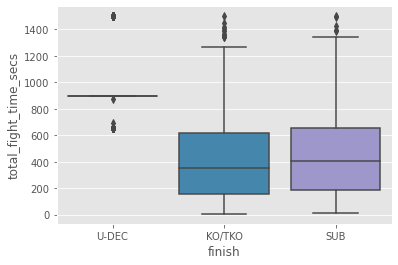

In [61]:
sns.boxplot(x='finish', y='total_fight_time_secs', data=train_df);

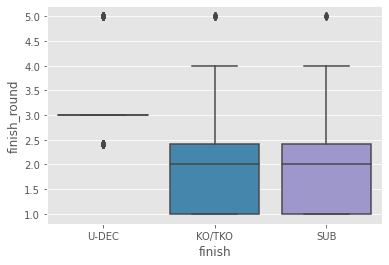

In [62]:
sns.boxplot(x='finish', y='finish_round', data=train_df);

### 4) Classification

### a) Baseline Logistic Regression Model

In [83]:
!conda install -c conda-forge imbalanced-learn

^C


In [88]:
logit = LogisticRegression(C=0.95)
logit.fit(X_train, y_train)


C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.95)

In [89]:
y_train_preds = logit.predict(X_train)
y_val_preds = logit.predict(X_val)

In [90]:
print('Logistic Regression training scores:')
print("accuracy score:",accuracy_score(y_train, y_train_preds))
print("f1 score:",f1_score(y_train, y_train_preds, average='macro'))
print("precision score:",precision_score(y_train, y_train_preds, average='macro'))
print("recall score:",recall_score(y_train, y_train_preds, average='macro'))
f_bta = fbeta_score(y_train, y_train_preds, beta = 2, average='macro' )
print("fbeta 2 score:",f_bta)

Logistic Regression training scores:
accuracy score: 0.7591792656587473
f1 score: 0.6342631418740474
precision score: 0.6681156631736823
recall score: 0.6469589088056203
fbeta 2 score: 0.6386905040020346


In [91]:
print('Logistic Regression validation scores:')
print("accuracy score:",accuracy_score(y_val, y_val_preds))
print("f1 score:",f1_score(y_val, y_val_preds, average='macro'))
print("precision score:",precision_score(y_val, y_val_preds, average='macro'))
print("recall score:",recall_score(y_val, y_val_preds, average='macro'))
f_bta = fbeta_score(y_val, y_val_preds, beta = 2, average='macro' )
print("fbeta 2 score:",f_bta)

Logistic Regression validation scores:
accuracy score: 0.7885652642934197
f1 score: 0.6710075120716753
precision score: 0.7103643282298592
recall score: 0.6764790336513635
fbeta 2 score: 0.6708837523895204


In [74]:
print('Logistic Regression confusion matrix: \n\n', confusion_matrix(y_val, logit.predict(X_val)))

Logistic Regression confusion matrix: 

 [[244  22  23]
 [ 21 447  10]
 [106  14  40]]


In [86]:
#exp 1 random down sample

us = imblearn.under_sampling.RandomUnderSampler()
X2, y2 = us.fit_resample(X_train ,y_train)

train_us = pd.concat([X2,y2], axis=1)
train_df.finish.value_counts()

U-DEC     1810
KO/TKO    1201
SUB        693
Name: finish, dtype: int64

In [87]:
train_us.finish.value_counts()

1    693
2    693
0    693
Name: finish, dtype: int64

In [101]:
logit2 = LogisticRegression(C=0.95)
logit2.fit(X2, y2)


C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.95)

In [104]:
y2_train_preds = logit2.predict(X2)
y2_val_preds = logit2.predict(X2) #dont have a validation set?

In [94]:
# thats better
print('Logistic Regression down sampling training scores:')
print("accuracy score:",accuracy_score(y2, y2_train_preds))
print("f1 score:",f1_score(y2, y2_train_preds, average='macro'))
print("precision score:",precision_score(y2, y2_train_preds, average='macro'))
print("recall score:",recall_score(y2, y2_train_preds, average='macro'))
f_bta = fbeta_score(y2, y2_train_preds, beta = 2, average='macro' )
print("fbeta 2 score:",f_bta)

Logistic Regression down sampling training scores:
accuracy score: 0.6993746993746994
f1 score: 0.6973249550314194
precision score: 0.6961212499255978
recall score: 0.6993746993746993
fbeta 2 score: 0.6984558190431738


In [95]:
print('Logistic Regression down sampling validation scores:')
print("accuracy score:",accuracy_score(y2, y2_val_preds))
print("f1 score:",f1_score(y2, y2_val_preds, average='macro'))
print("precision score:",precision_score(y2, y2_val_preds, average='macro'))
print("recall score:",recall_score(y2, y2_val_preds, average='macro'))
f_bta = fbeta_score(y2, y2_val_preds, beta = 2, average='macro' )
print("fbeta 2 score:",f_bta)

Logistic Regression down sampling validation scores:
accuracy score: 0.6993746993746994
f1 score: 0.6973249550314194
precision score: 0.6961212499255978
recall score: 0.6993746993746993
fbeta 2 score: 0.6984558190431738


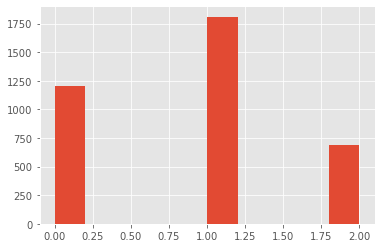

In [79]:
y_train.hist()

In [73]:
logit.predict_proba(X_val[:])

array([[2.50537615e-05, 9.99959960e-01, 1.49860106e-05],
       [3.79341421e-01, 2.27586366e-01, 3.93072213e-01],
       [6.74046450e-04, 9.99065176e-01, 2.60777243e-04],
       ...,
       [2.58323423e-02, 9.64800113e-01, 9.36754430e-03],
       [7.24533521e-01, 6.17244203e-05, 2.75404755e-01],
       [5.05056996e-01, 2.15243632e-01, 2.79699372e-01]])

In [75]:
lm1 = LogisticRegression(C = 1000)
lm1.fit(X_train[['finish_round']], y_train)

LogisticRegression(C=1000)

In [76]:
# total_fight_time_secs = 0.73
lm1.score(X_train[['finish_round']], y_train)

0.7224622030237581

In [77]:
#more than one feature
#StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance
std_scale = StandardScaler()

X_train2 = train_df[['total_fight_time_secs', 'finish_round']]
X_train2_scaled = std_scale.fit_transform(X_train2)

lm2 = LogisticRegression()
lm2.fit(X_train2_scaled, y_train)

y_predict = lm2.predict(X_train2_scaled)
lm2.score(X_train2_scaled, y_train)

0.740280777537797

### b) KNN

In [128]:
# Train on training set, and validate on validation set
# precision and recall (still got to do) from classification_error_metrics_student notebook
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred)) #compares between y_val(actual) and y_pred (predicted)


0.761596548004315


C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [129]:
# is this different than accuracy? i think yes
print('KNN training score: ', knn.score(X_train, y_train))
print('KNN validation score: ', knn.score(X_val, y_val))

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


KNN training score:  0.7815874730021598
KNN validation score:  0.761596548004315


C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [130]:
print('kNN confusion matrix: \n\n', confusion_matrix(y_val, knn.predict(X_val)))

kNN confusion matrix: 

 [[211  37  41]
 [ 23 451   4]
 [ 84  32  44]]


C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# knn_confusion = confusion_matrix(y_val, knn.predict(X_val))
# plt.figure(dpi = 150)
# sns.heatmap(knn_confusion, cmap = plt.cm.Blues, annot = True, square = True,
#             xticklabels = train_df['finish'],
#             yticklabels = train_df['finish'])

# plt.xlabel('Predicted finish')
# plt.ylabel('Actual finish')
# plt.title('kNN confusion matrix');


In [131]:
# KNN cross validation
knn2 = KNeighborsClassifier(n_neighbors = 10)
scores = cross_val_score(knn2, X, y, cv = 10, scoring = 'accuracy')
print(scores)

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

[0.5625     0.71274298 0.75809935 0.73866091 0.76889849 0.7537797
 0.77321814 0.76673866 0.79265659 0.73434125]


C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [132]:
print(scores.mean())

0.736163606911447


In [133]:
#finding best KNN k value
# k = 10 is best 0.736
k_range = list(range(1,100))
k_scores = []

for k in k_range:
    knn3 = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn3, X, y, cv = 10, scoring = 'accuracy')
    k_scores.append(scores.mean())
print(k_scores)    
    

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\x-x-f\anaconda3\lib\site-packages\sklearn\base.py:441: UserWa

[0.686077027630893, 0.6808999590377598, 0.7156610747002309, 0.7264555559693157, 0.7208441945334029, 0.7275336076562151, 0.7283933492217175, 0.7337873314962389, 0.7348658486631414, 0.736163606911447, 0.7324891077679303, 0.7342174350189915, 0.7301146942727341, 0.7350827623445296, 0.735297348625903, 0.7352968831459001, 0.7361603485514262, 0.7327060214493185, 0.7340019177776123, 0.7303306769941164, 0.7292507633872048, 0.7298963841513368, 0.7281675914202727, 0.7303264876740896, 0.7303255567140835, 0.7298921948313101, 0.7275173158561108, 0.7285962985030163, 0.7275173158561108, 0.7244949541967678, 0.7236300923512327, 0.7249255231995233, 0.7281629366202427, 0.726004505846429, 0.7262209540478141, 0.7244944887167646, 0.7236296268712297, 0.7262218850078201, 0.7238451441126089, 0.7247081440381321, 0.7251415059209056, 0.7260049713264318, 0.7238451441126088, 0.7249255231995233, 0.7244944887167647, 0.7255739368436731, 0.7227661614657034, 0.7236296268712297, 0.7223337305429358, 0.7206054032918746, 0.7

In [ ]:
#Grid search CV ----> used to find the best hyperparameter
k_range = list(range(1,100))
print(k_range)

In [ ]:
param_grid = dict(n_neighbors = k_range)
print(param_grid)

In [ ]:
# instantiate the grid
grid = GridSearchCV(knn3, param_grid, cv=10, scoring = 'accuracy')

In [ ]:
#X, y are before the split
grid.fit(X,y)

In [ ]:
grid.cv_results_

In [ ]:
print('best params: ', grid.best_params_)
print('best estimator: ', grid.best_estimator_)
print('best score: ', grid.best_score_)

### C) Decision Trees

In [146]:
#decision tree score on training:
decisiontree = DecisionTreeClassifier(max_depth = 5) #why use max_depth?
decisiontree.fit(X_train, y_train)
decisiontree.score(X_train, y_train)

0.8083153347732182

In [147]:
#what?
y_pred = decisiontree.predict(X_val)
decisiontree.score(X_val, y_pred)

1.0

In [148]:
#decision tree score on validation:
decisiontree.score(X_val, y_val)

0.8187702265372169

In [149]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [150]:
train_preds = dt.predict(X_train)
val_preds = dt.predict(X_val)

In [151]:
#decision tree scores on train
print("accuracy score:",accuracy_score(y_train, train_preds))
print("f1 score:",f1_score(y_train, train_preds, average='macro'))
print("precision score:",precision_score(y_train, train_preds, average='macro'))
print("recall score:",recall_score(y_train, train_preds, average='macro'))
f_bta = fbeta_score(y_train, train_preds, beta = 2, average='macro' )
print("fbeta 2 score:",f_bta)

accuracy score: 1.0
f1 score: 1.0
precision score: 1.0
recall score: 1.0
fbeta 2 score: 1.0


In [152]:
#decision tree scores on validation
print("accuracy score:",accuracy_score(y_val, val_preds))
print("f1 score:",f1_score(y_val, val_preds, average= 'macro'))
print("precision score:",precision_score(y_val, val_preds, average= 'macro'))
print("recall score:",recall_score(y_val, val_preds, average='macro'))
f_bta = fbeta_score(y_val, val_preds, beta = 2, average='macro' )
print("fbeta 2 score:",f_bta)

accuracy score: 0.7885652642934197
f1 score: 0.7116454846924952
precision score: 0.7102255341622562
recall score: 0.7146774997225078
fbeta 2 score: 0.7132573599575496


### D) Random Forest

In [141]:
#Random forest score on training
randomforest = RandomForestClassifier(n_estimators = 100)
randomforest.fit(X_train, y_train)
randomforest.score(X_train, y_train)

1.0

In [142]:
#Random forest score on validation
randomforest.score(X_val, y_val)

0.8317152103559871

In [143]:
train_preds2 = randomforest.predict(X_train)
val_preds2 = randomforest.predict(X_val)

In [144]:
#Random forest scores on train
print("accuracy score:",accuracy_score(y_train, train_preds2))
print("f1 score:",f1_score(y_train, train_preds2, average='micro'))
print("precision score:",precision_score(y_train, train_preds2, average='micro'))
print("recall score:",recall_score(y_train, train_preds2, average='micro'))
f_bta = fbeta_score(y_train, train_preds2, beta = 2, average='micro' )
print("fbeta 2 score:",f_bta)

accuracy score: 1.0
f1 score: 1.0
precision score: 1.0
recall score: 1.0
fbeta 2 score: 1.0


In [145]:
#decision tree scores on validation
print("accuracy score:",accuracy_score(y_val, val_preds2))
print("f1 score:",f1_score(y_val, val_preds2, average='macro'))
print("precision score:",precision_score(y_val, val_preds2, average='macro'))
print("recall score:",recall_score(y_val, val_preds2, average='macro'))
f_bta = fbeta_score(y_val, val_preds2, beta = 2, average='macro' )
print("fbeta 2 score:",f_bta)

accuracy score: 0.8317152103559871
f1 score: 0.7336282158363415
precision score: 0.7782529791116352
recall score: 0.7315653458035934
fbeta 2 score: 0.7288214754959336
